In [1]:
# Preprocessing reddit data for sentiment analysis (Capstone 1)
# import necessary libraries
# help from this code: https://www.kaggle.com/kritanjalijain/twitter-sentiment-analysis-lstm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re    # RegEx (remove non-letter characters)
import nltk  # natural language processing toolkit
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# Modeling
from sklearn.model_selection import train_test_split
# import tensorflow as tf # Python 3.8 does not support tensorflow
import seaborn as sns

# Data visualization
import matplotlib.patches as mpatches
%matplotlib inline

# pd.options.plotting.backend = "plotly"
# from library.sb_utils import save_file
red = pd.read_csv('Reddit_data.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hillarylevinson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# print first 5 rows:
red.head()
# For category column, 1 = positive, 0 = neutral, -1 = negative sentiments

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [4]:
# number of missing values by column
# missing = pd.concat([red.isnull().sum(), 100 * red.isnull().mean()], axis=1)
# missing.columns=['count', '%']
# missing.sort_values(by='count')

In [5]:
red.isnull().sum()

clean_comment    100
category           0
dtype: int64

In [6]:
# clean up empty cells
red.dropna(axis=0, inplace=True)

In [7]:
red.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [8]:
red.shape

(37149, 2)

In [9]:
# Map comment categories
red['category'] = red['category'].map({-1:'Negative', 0:'Neutral', 1:'Positive'})
# Output first five rows
red.head()

,clean_comment,category
0,family mormon have never tried explain them t...,Positive
1,buddhism has very much lot compatible with chr...,Positive
2,seriously don say thing first all they won get...,Negative
3,what you have learned yours and only yours wha...,Neutral
4,for your own benefit you may want read living ...,Positive


<AxesSubplot:xlabel='category'>

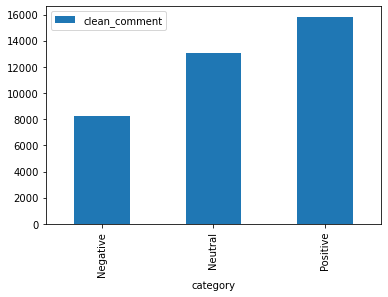

In [10]:
# Visualize
red.groupby('category').count().plot(kind='bar')

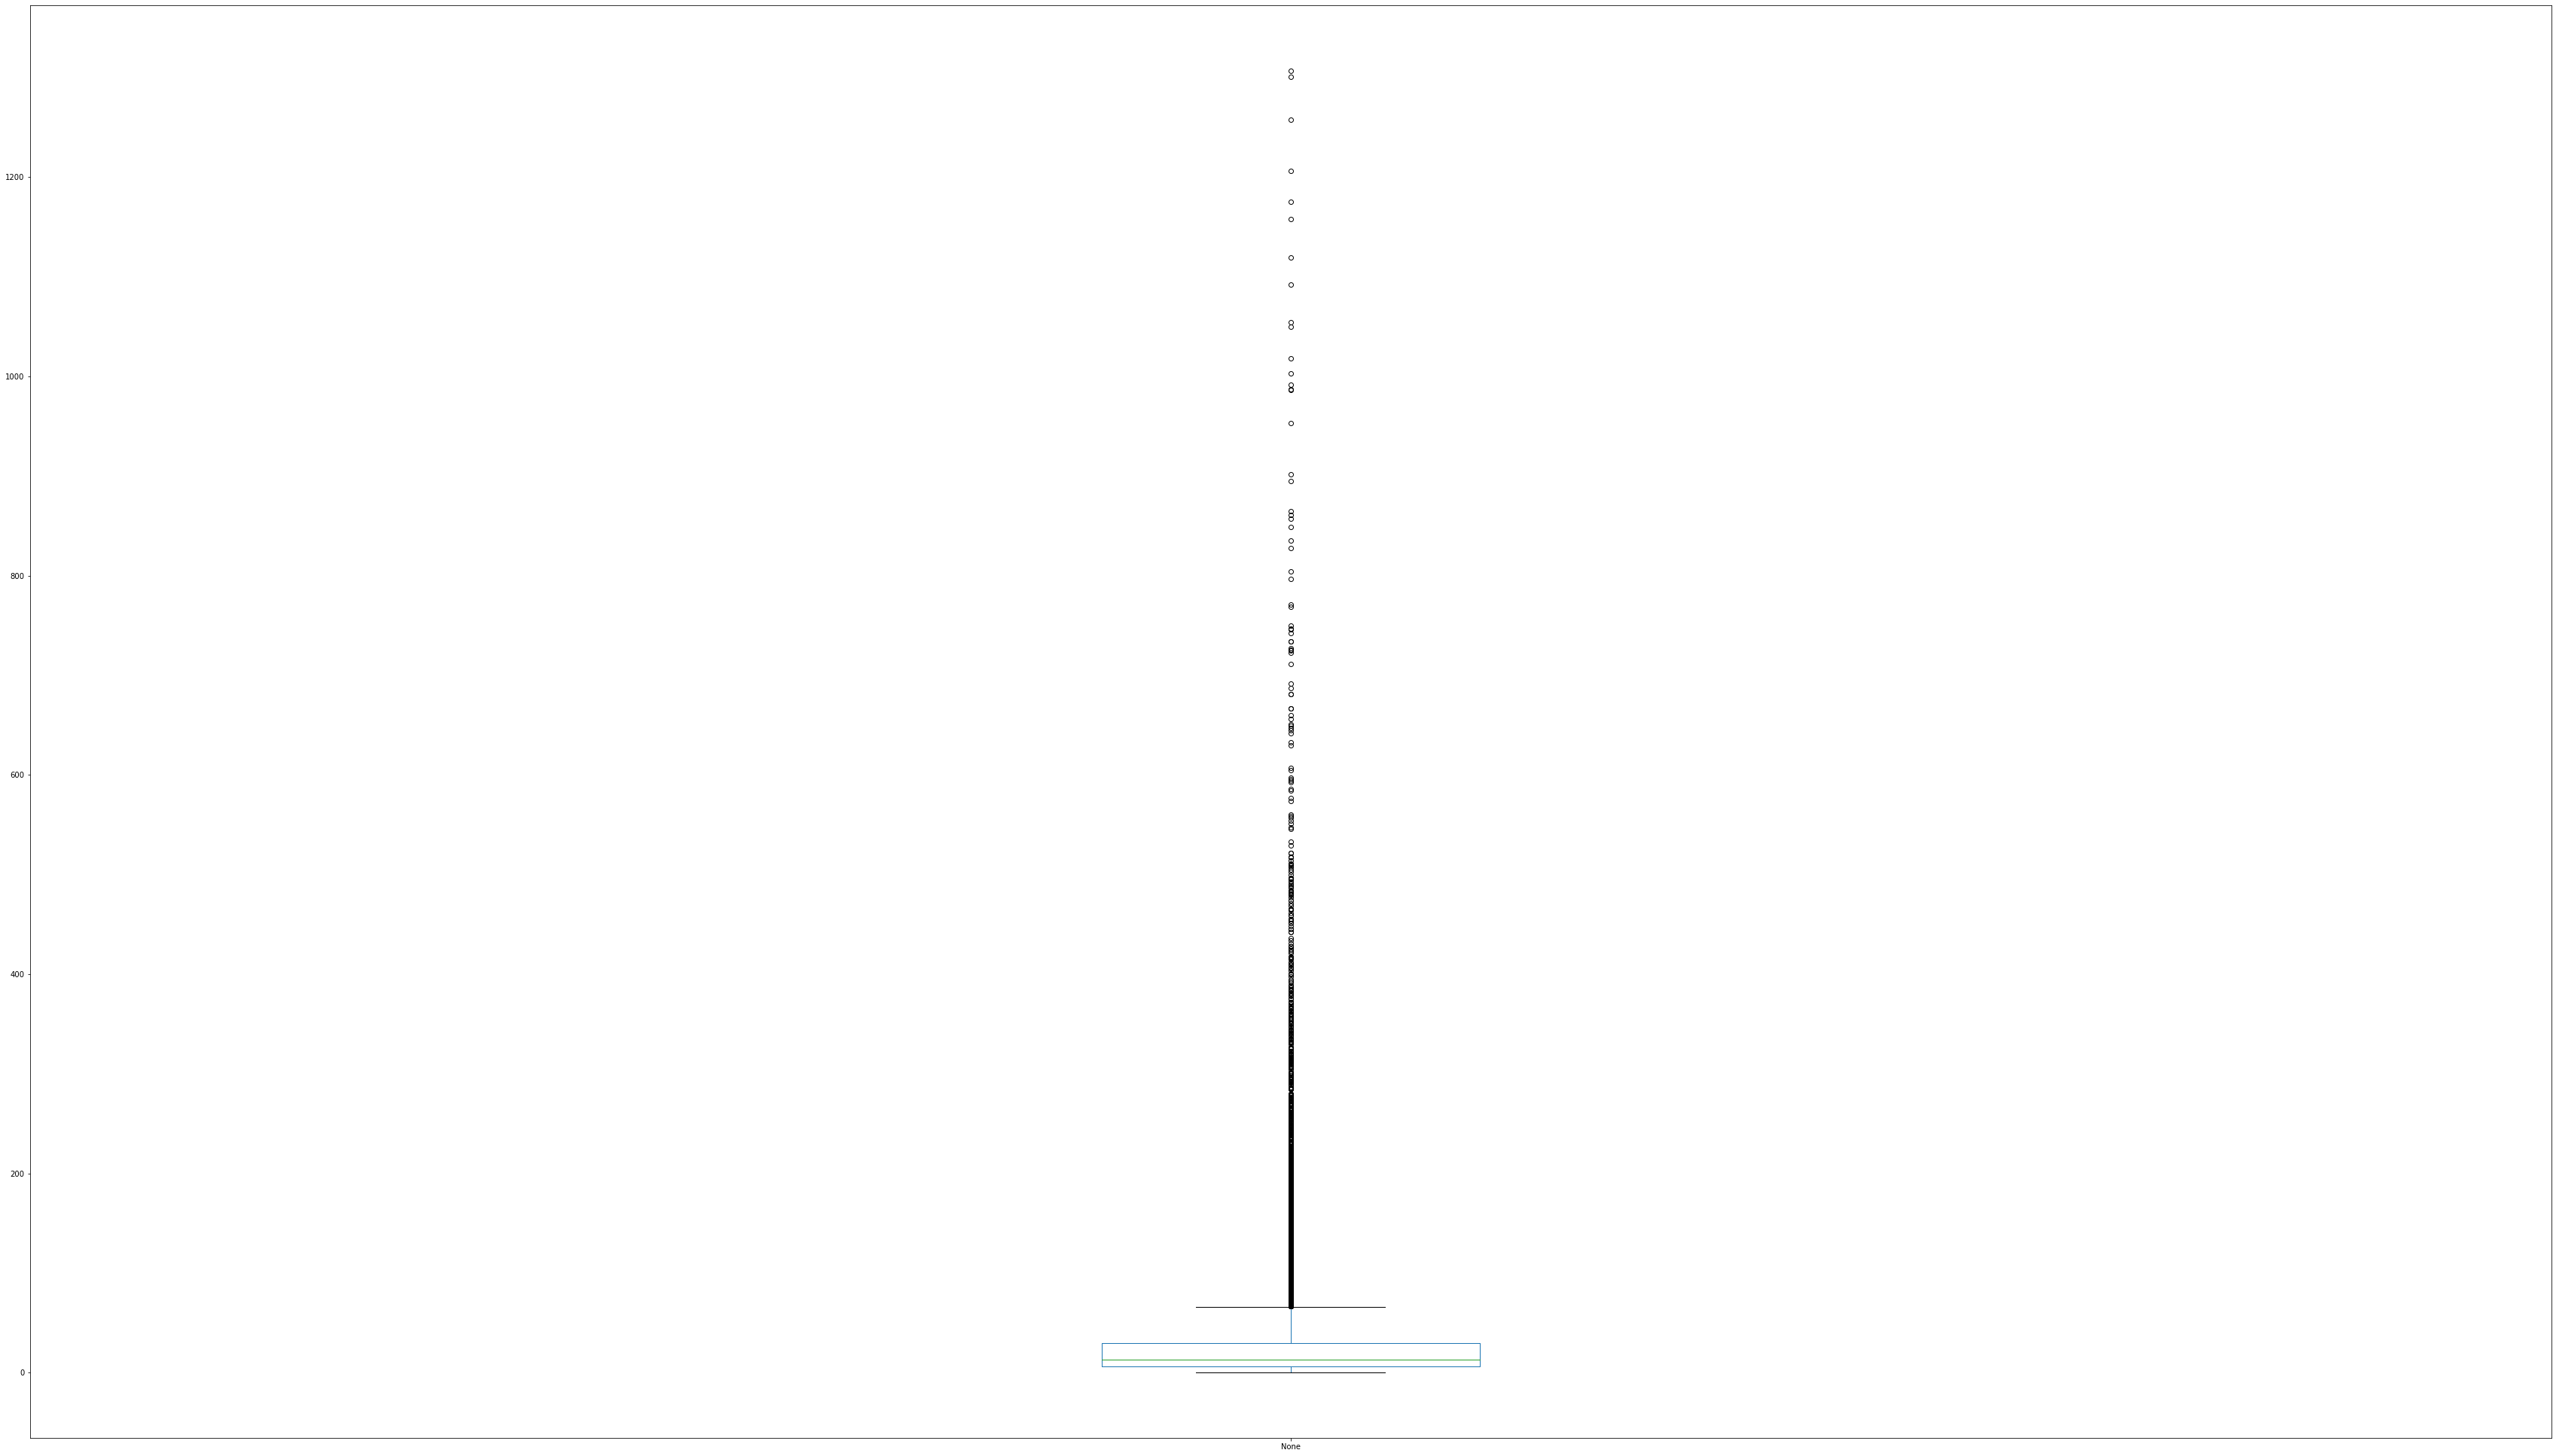

In [18]:
# Calculate comment lengths
com_len = pd.Series([len(com.split()) for com in red['clean_comment']])

# The distribution of tweet text lengths
fig = com_len.plot(kind='box', figsize=(60,35))

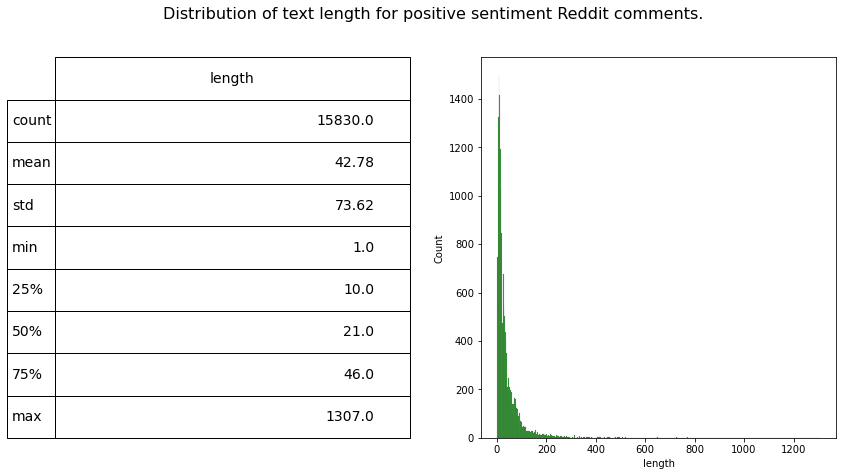

In [20]:
# Plotting positive sentiment comments
fig = plt.figure(figsize=(14,7))
red['length'] = red.clean_comment.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(red[red['category']=='Positive']['length'], ax=ax1,color='green')
describe = red.length[red.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment Reddit comments.', fontsize=16)

plt.show()

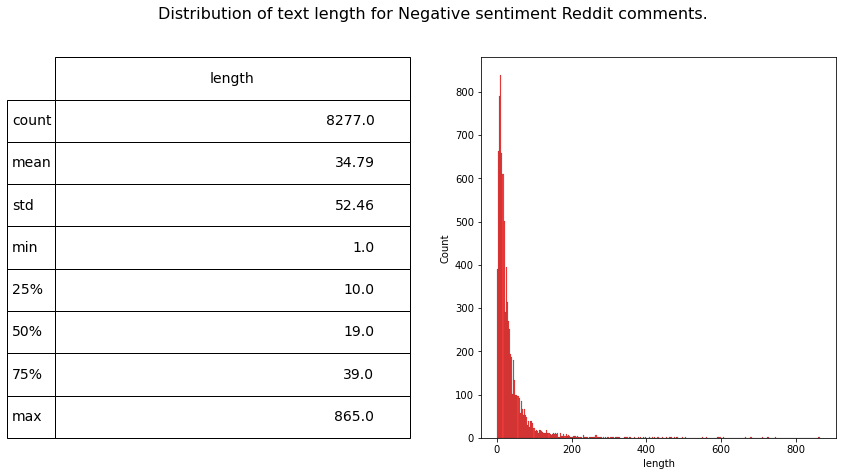

In [21]:
# Plotting negative sentiment comments
fig = plt.figure(figsize=(14,7))
red['length'] = red.clean_comment.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(red[red['category']=='Negative']['length'], ax=ax1,color='red')
describe = red.length[red.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment Reddit comments.', fontsize=16)

plt.show()

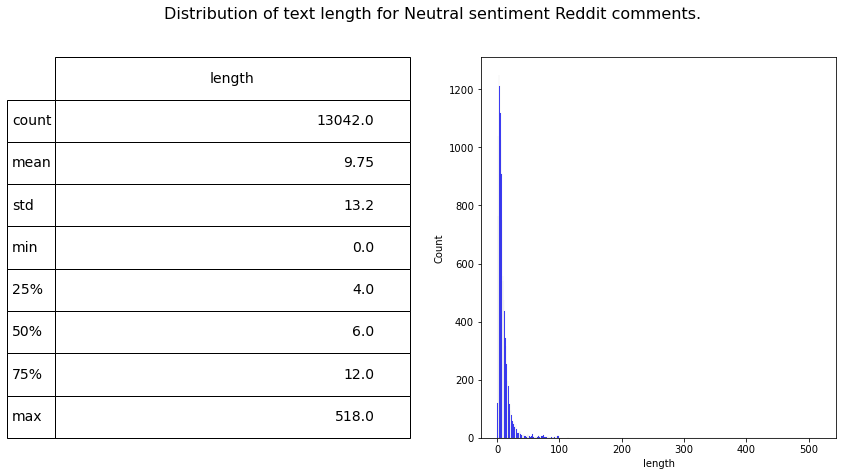

In [22]:
# Plotting neutral sentiment comments
fig = plt.figure(figsize=(14,7))
red['length'] = red.clean_comment.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(red[red['category']=='Neutral']['length'], ax=ax1,color='blue')
describe = red.length[red.category=='Neutral'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Neutral sentiment Reddit comments.', fontsize=16)

plt.show()

In [23]:
import plotly.express as px
fig = px.pie(red, names='category', title ='Pie chart of different sentiments of Reddit comments')
fig.show()

ModuleNotFoundError: No module named 'plotly'